In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from layers import CompressionLayer, QuantizationLayer, FeatureSelectionLayer
from models import MLP_small, MLP_small_per_feature, Combined_Model
from training_utils import train_model, eval_val

## Load California Housing

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for regression
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

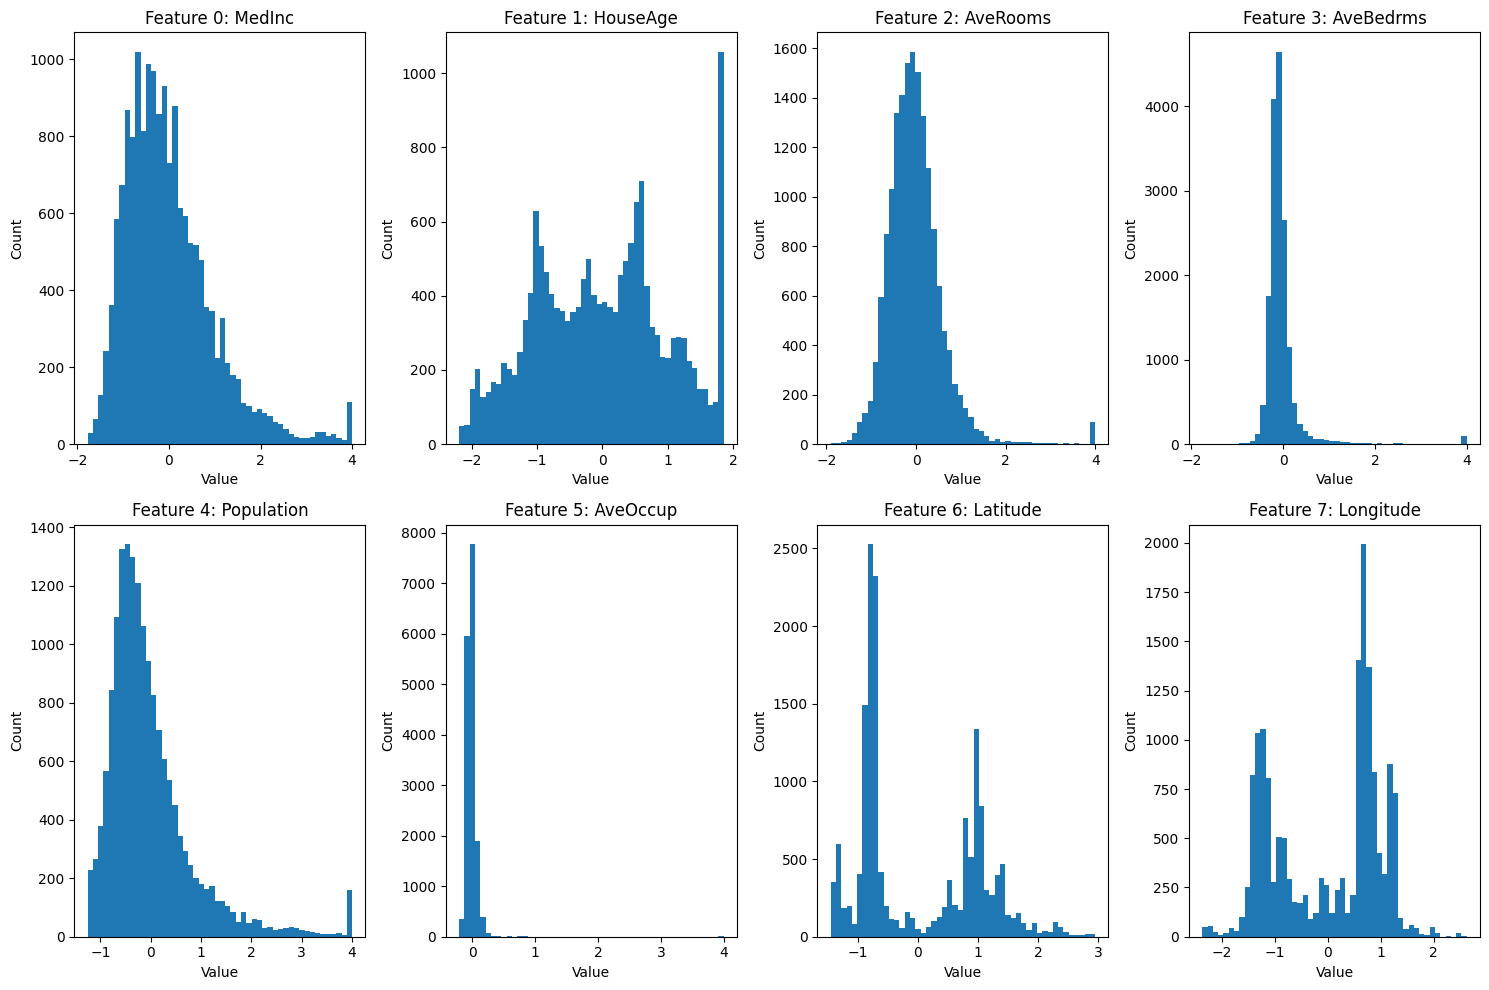

In [4]:
# Plot histograms for all features in X_train
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.hist(np.clip(X_train[:, i], -4,4), bins=50)
    plt.title(f'Feature {i}: {data.feature_names[i]}')
    plt.xlabel('Value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


## Test on California Housing Dataset

We test the following models on California Housing:
Comparison model with number of neurons per layer: (8,64,64,1)
Combined model with number of neurons per layer: (8,64,64,1) --> Here, the ouput of the first layer is calculated using the learnable thresholds and the sigmoid function. Note that we use 8 thresholds per feature.

In [5]:
def initialize_a(num_features, num_thresholds_per_feature, X):
    """Initializes a_init and a_index for the CompressedModel. Each feature will have num_thresholds_per_feature thresholds. 
    They are initialized as quantiles of the data.

    Args:
        num_features (int): _description_
        num_thresholds (int): _description_
        X (tensor): _description_

    Returns:
        a_init: initial threshold values, shape [num_features * num_thresholds_per_feature]
        a_index: a_index[f] is the index of the feature that threshold f belongs to, shape [num_features * num_thresholds_per_feature]
    """
    quantiles_tensor = torch.tensor([(f+1)*1/(num_thresholds_per_feature+1) for f in range(num_thresholds_per_feature)])
    a_init = torch.quantile(X, quantiles_tensor, dim = 0).T.flatten()
    a_index = torch.repeat_interleave(torch.arange(num_features), num_thresholds_per_feature)
    return a_init, a_index

In [6]:
device = 'cpu'

In [7]:
linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
linear_comparison_model.to(device);

In [8]:
a_init, a_index = initialize_a(8, 8, X_train_tensor)

In [9]:
compression_model = CompressionLayer(a_init, a_index)
linear_model = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = Combined_Model(start_model=nn.Identity(), 
                                quantization_layer=compression_model, 
                                end_model=linear_model)
combined_model.to(device);

In [10]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
n_epochs = 20
# train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs, device=device)
train_model(model=linear_comparison_model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            num_epochs=n_epochs, 
            device=device,
            has_quantization_layer=False)

Epoch 1/20, Loss: 0.7003761189159496, Val Loss: 0.40818482408156764
Epoch 3/20, Loss: 0.3612597078489241, Val Loss: 0.36844656329888564
Epoch 5/20, Loss: 0.33530156221962715, Val Loss: 0.3376503389615279
Epoch 7/20, Loss: 0.32176404053619667, Val Loss: 0.40066815591775456
Epoch 9/20, Loss: 0.30397641069667286, Val Loss: 0.3046343067517647
Epoch 11/20, Loss: 0.29420710265520933, Val Loss: 0.2969508579144111
Epoch 13/20, Loss: 0.285267716085957, Val Loss: 0.2933340753500278
Epoch 15/20, Loss: 0.2798518830145052, Val Loss: 0.28833957337416133
Epoch 17/20, Loss: 0.27898402289711227, Val Loss: 0.29094718625912297
Epoch 19/20, Loss: 0.2741733016085255, Val Loss: 0.28365343717428354


0.29872619555546687

In [11]:
## Train combined model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
n_epochs = 20
train_model(model=combined_model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            num_epochs=n_epochs, 
            device=device,
            has_quantization_layer=True,
            train_quantization_layer=True,
            decrease_factor=0.001)

Epoch 1/20, Loss: 0.8612924498874087, Val Loss: 0.646249568920869
Epoch 3/20, Loss: 0.4833466494383738, Val Loss: 0.6137480868743016
Epoch 5/20, Loss: 0.39681749045848846, Val Loss: 0.4706537677691533
Epoch 7/20, Loss: 0.3427730573471202, Val Loss: 0.4746944592549251
Epoch 9/20, Loss: 0.3045820629354133, Val Loss: 0.3670963521187122
Epoch 11/20, Loss: 0.28619747776393745, Val Loss: 0.32877593155090623
Epoch 13/20, Loss: 0.27479255130124647, Val Loss: 0.29617121746906866
Epoch 15/20, Loss: 0.27605190506392674, Val Loss: 0.29674289364081163
Epoch 17/20, Loss: 0.2769093382381654, Val Loss: 0.3038756007185349
Epoch 19/20, Loss: 0.2778357882774615, Val Loss: 0.2990597277879715


0.3088997210447605

In [24]:
combined_model

Combined_Model(
  (start_model): Identity()
  (quantization_layer): CompressionLayer()
  (end_model): MLP_small(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [23]:
dir(combined_model.forward())

TypeError: Combined_Model.forward() missing 1 required positional argument: 'x'

In [20]:
x,y = next(iter(test_loader))
combined_model(x)

TypeError: Combined_Model.forward() got an unexpected keyword argument 'eval'

In [12]:
eval_val(linear_comparison_model, test_loader,device=device), eval_val(combined_model, test_loader,device=device), eval_val(combined_model, test_loader, eval=True,device=device)

TypeError: Combined_Model.forward() got an unexpected keyword argument 'eval'

In [348]:
def eval_compression(model, val_dataloader, device = 'cuda'):
    """Calculates, how far the model is from giving compressed hidden states.

    Args:
        model: important: model.forward() must return hidden_state, output
        val_dataloader: dataloader of validation set
        device (str, optional): device. Defaults to 'cuda'.

    Returns:
        : mean of the absolute difference between hidden state and rounded (i.e. compressed) hidden state
    """
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            hidden_state, output = model(x)   
            hidden_state_compressed = torch.round(hidden_state) 
            loss = torch.mean(torch.abs(hidden_state - hidden_state_compressed))
            losses.append(loss.item())
        return np.mean(losses)

In [349]:
eval_compression(combined_model, test_loader,device=device)

0.0012575185208473928

## Evaluate multiple trainings

Let us evaluate multiple trainings for Comparison Model and Combined Model, so that we can see, which one is better in average.

In [351]:
val_losses_comparison = []
for f in tqdm(range(20)):
    linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
    linear_comparison_model.to(device);
    n_epochs=40
    optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False, device = device)
    val_losses_comparison.append(val_loss_current)
    

100%|██████████| 20/20 [05:02<00:00, 15.13s/it]


In [353]:
val_losses_combined = []
val_losses_compressed = []
for f in tqdm(range(20)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = 64,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    n_epochs=40
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False, device =device)
    val_losses_combined.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval = True, device = device)
    val_losses_compressed.append(val_loss_current)
    

100%|██████████| 20/20 [05:05<00:00, 15.25s/it]


/tmp/ipykernel_2702327/4207345447.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([val_losses_comparison, val_losses_combined, val_losses_compressed], labels=['Comparison', 'Combined', 'Compressed'])


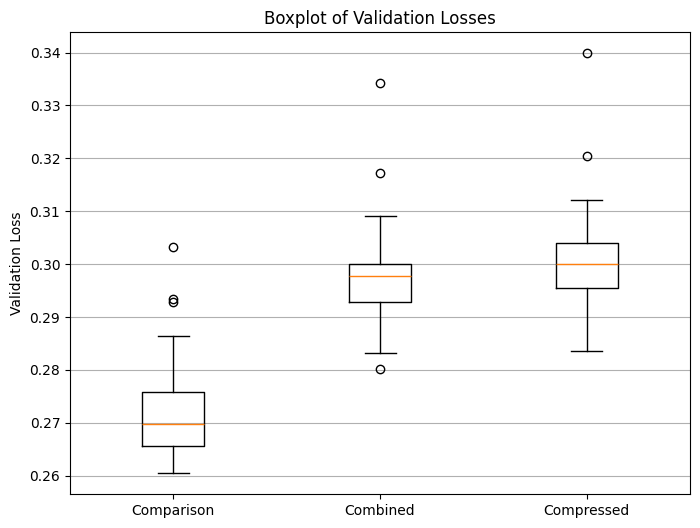

In [354]:
plt.figure(figsize=(8, 6))
plt.boxplot([val_losses_comparison, val_losses_combined, val_losses_compressed], labels=['Comparison', 'Combined', 'Compressed'])
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()

The combined model performs not as good as the comparison model, but it is also not that far away.

## How much threshold should be used?

Lets evaluate, how the amount of thresholds influence the results.

In [30]:
min_thresholds = 1
max_thresholds = 15
num_features = 8
n_epochs = 20
n_runs_per_threshold = 10
val_losses = np.zeros((max_thresholds-min_thresholds+1, n_runs_per_threshold))
val_losses_compressed = np.zeros((max_thresholds-min_thresholds+1, n_runs_per_threshold))
device = 'cpu'

for num_thresholds in tqdm(range(min_thresholds,max_thresholds+1)):
    a_init, a_index = initialize_a(num_features, num_thresholds, X_train_tensor)
    for run in range(n_runs_per_threshold):
        compressed_model = CompressedModel(a_init, a_index)
        linear_model = MLP_small(in_features = num_thresholds*num_features,
                                out_features = 1,
                                hidden_features = 64,
                                num_layers = 2)
        combined_model = CombinedModel(compressed_model, linear_model)
        combined_model.to(device);
        optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
        criterion = nn.MSELoss()
        val_loss_current = train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False, device= device)
        val_losses[num_thresholds-min_thresholds, run] = val_loss_current
        val_loss_current = eval_val(combined_model, test_loader, eval = True, device = device)
        val_losses_compressed[num_thresholds-min_thresholds, run] = val_loss_current


100%|██████████| 15/15 [18:20<00:00, 73.35s/it]


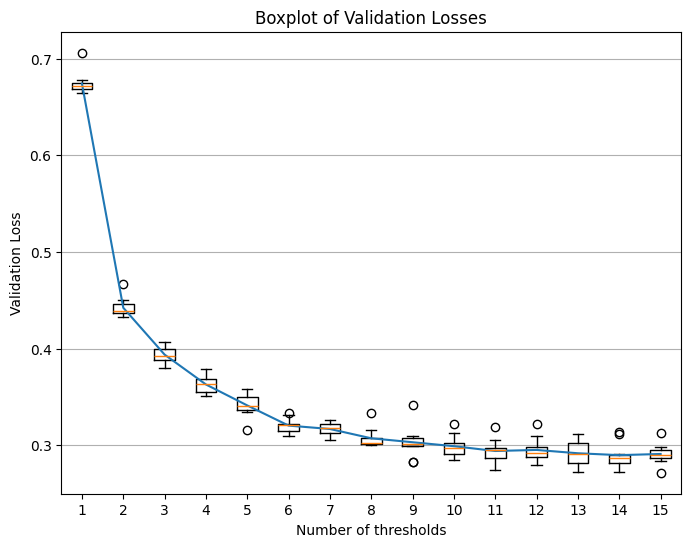

In [34]:
plt.figure(figsize=(8, 6))
plt.boxplot(val_losses.T, tick_labels=range(min_thresholds, max_thresholds + 1))
plt.plot(range(min_thresholds, max_thresholds+1), np.mean(val_losses, axis=1))    
plt.xlabel('Number of thresholds')
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()

## Plot models decision boundaries

Text(0.5, 1.0, 'Initial Decision Steps')

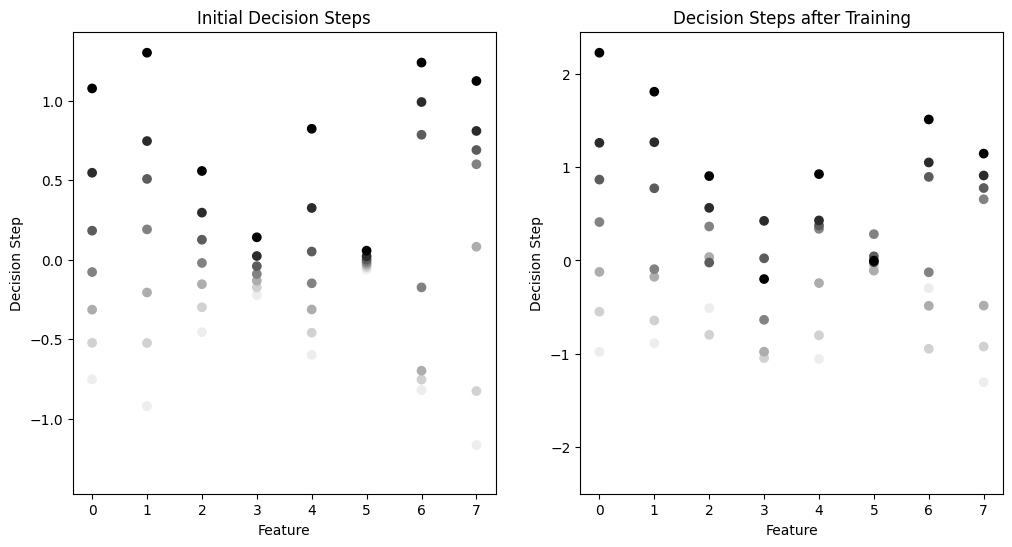

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,2)
for f in range(8):
    plt.scatter(f*np.ones(8), combined_model.compressed_model.a[f*8:(f+1)*8].detach().cpu().numpy(), c = np.arange(8), cmap= 'Greys')
plt.xticks(np.arange(8), np.arange(8)) 
plt.xlabel('Feature')
plt.ylabel('Decision Step')
plt.title('Decision Steps after Training')

plt.subplot(1,2,1)
for f in range(8):
    plt.scatter(f*np.ones(8), a_init[f*8:(f+1)*8],  c = np.arange(8), cmap= 'Greys')
plt.xticks(np.arange(8), np.arange(8)) 
plt.xlabel('Feature')
plt.ylabel('Decision Step')
plt.title('Initial Decision Steps')

## Comparison Trees

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")


Random Forest MSE: 0.47345772327303354


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=256, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")

Random Forest MSE: 0.6027969396916061


In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")

Decision Tree MSE: 0.4972838079675652


## Test Linear Regression Model

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

Linear Regression MSE: 0.5558915986952442


In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the linear regression model
poly_linear_model = LinearRegression()
poly_linear_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_poly = poly_linear_model.predict(X_test_poly)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print(f"Polynomial Linear Regression MSE: {mse_poly}")

Polynomial Linear Regression MSE: 0.46430152383011586


In [50]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the Lasso Linear Regression model
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test_poly)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso Linear Regression MSE: {mse_lasso}")

Lasso Linear Regression MSE: 0.6135867129893572


## Automatic Feature Selection

We want to decide automatically, which feature to use how often, i.e. which feature should get how much thresholds.

In [ ]:
class FeatureSelectionLayer(nn.Module):
    """A layer that selects one of two features per output value based on a sigmoid function."""
    def __init__(self, first_index, second_index, tau=1.) -> None:
        """Initializes the layer.

        Args:
            first_index (tensor): First index of comparison, shape [out_features]
            second_index (s): Second index of comparison, shape [out_features]
            tau (float, optional): Sharpening factor. Defaults to 1.
        """
        super().__init__()
        self.first_index = first_index
        self.second_index = second_index
        out_features = len(second_index)
        self.sigmoid_factor = nn.Parameter(torch.zeros(out_features))
        self.sigmoid = nn.Sigmoid()
        self.tau = tau

    def forward(self, x: torch.Tensor, eval = False) -> torch.Tensor:
        """Using the sigmoid_factor, we calculate how much of the first feature should be used per output value.  

        Args:
            x (torch.Tensor): input tensor, shape [B, num_features]
            eval (bool, optional): If True, sigmoid_factor is rounded (i.e. compressed). Defaults to False.

        Returns:
            torch.Tensor: Selected feature, shape [B, out_features]
        """
        self.factor = self.sigmoid(self.sigmoid_factor / self.tau)
        if eval:
            self.factor = torch.round(self.factor)
        return x[:,self.first_index] * self.factor  + x[:,self.second_index] * (1-self.factor) 
    
    def get_features(self):
        """Returns the index of the selected feature for each output value."""
        feature_index = torch.where(self.sigmoid_factor.to('cpu') >= 0, self.first_index, self.second_index)
        return feature_index


In [ ]:
class CombinedModelNew(nn.Module):
    """New Class of combined model, containing a feature selection layer, a compressed model and a linear model."""
    def __init__(self, feature_selection_layer, compressed_model, linear_model) -> None:
        super().__init__()
        self.feature_selection_layer = feature_selection_layer
        self.compressed_model = compressed_model
        self.linear_model = linear_model

    def forward(self, x: torch.Tensor, eval = False) -> torch.Tensor:
        feature_selected = self.feature_selection_layer(x, eval = eval)
        hidden_state = self.compressed_model(feature_selected, eval = eval)
        y = self.linear_model(hidden_state)
        return hidden_state, y

In [ ]:
def train_combined_model_new(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print_result=True):
    """Trains a combined model. Difference to train_combined_model: tau is set for feature selection layer and compressed model.

    Args:
        model: important: model.forward() must return hidden_state, output
        train_dataloader: dataloader of training set
        val_dataloader: dataloader of validation set	
        optimizer: optimizer to use
        criterion: loss criterion
        num_epochs: number of epochs to train
        device (str, optional): device. Defaults to 'cuda'.
        print_result (bool, optional): If true, method prints intermediate results. Defaults to True.

    Returns:
        val_loss: validation loss
    """
    factor = 0.001 ** (1/num_epochs)
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            hidden_state, output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        model.feature_selection_layer.tau = max(model.feature_selection_layer.tau * factor, 0.001)  
        model.compressed_model.tau = max(model.compressed_model.tau * factor, 0.001)  
        val_loss = eval_val(model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss


In [ ]:
## Initialize combined model new with feature selection layer
# Here, we use 64 thresholds and compare each pair of features once (also same feature with itself)
device = 'cpu'
num_thresholds = 64
num_features = 8
first_index = torch.repeat_interleave(torch.arange(num_features), num_thresholds // num_features)
second_index = torch.cat([torch.arange(num_thresholds//num_features) for _ in range(num_features)])
a_init = torch.randn(num_thresholds)
a_index = torch.arange(num_thresholds)

feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = num_thresholds,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)

combined_model_new.to(device);

In [127]:
feature_index_before = feature_selection_layer.get_features()

In [ ]:
## Train combined model new with feature selection layer

optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
criterion = nn.MSELoss()
n_epochs = 25
train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device)

Epoch 1/25, Loss: 0.8570191156725551, Val Loss: 0.6610307381703303
Epoch 3/25, Loss: 0.4757405345061029, Val Loss: 0.6307152619728675
Epoch 5/25, Loss: 0.4029388475672219, Val Loss: 0.6537017015310435
Epoch 7/25, Loss: 0.35042954692544864, Val Loss: 0.37368708573854886
Epoch 9/25, Loss: 0.3149165598343509, Val Loss: 0.4145399861610853
Epoch 11/25, Loss: 0.30449044011359994, Val Loss: 0.34489996891755326
Epoch 13/25, Loss: 0.2996857146364312, Val Loss: 0.3323380016363584
Epoch 15/25, Loss: 0.306452243422815, Val Loss: 0.3373555660247803
Epoch 17/25, Loss: 0.3051699461169945, Val Loss: 0.31565870848985816
Epoch 19/25, Loss: 0.29896523442494777, Val Loss: 0.3239848487652265
Epoch 21/25, Loss: 0.29611806161412896, Val Loss: 0.306457528930444
Epoch 23/25, Loss: 0.29588273375533347, Val Loss: 0.33726956569231475
Epoch 25/25, Loss: 0.31073992826448854, Val Loss: 0.328917205448334


0.328917205448334

In [130]:
eval_val(combined_model_new, test_loader, device = device), eval_val(combined_model_new, test_loader, eval=True, device = device)

(0.328917205448334, 0.3320779094329247)

In [131]:
feature_index_after = combined_model_new.feature_selection_layer.get_features()
feature_index_after

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 5, 6, 1, 0, 2, 2, 2, 2, 5, 6, 7,
        0, 3, 3, 3, 3, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 5, 3, 5, 5, 5, 5,
        0, 1, 6, 6, 6, 5, 6, 7, 0, 7, 2, 7, 7, 7, 7, 7])

Let's count the selected features. It turns out that they are not uniformly distributed.

In [ ]:
feature_idx, feature_count = torch.unique(feature_index_after, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7]), tensor([15,  6,  6,  7,  1, 11,  8, 10]))

In [133]:
torch.unique(feature_index_before, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7]), tensor([8, 8, 8, 8, 8, 8, 8, 8]))

In [143]:
runs = 10
device = 'cpu'
feature_count_total = torch.zeros(runs,num_features)
for f in tqdm(range(runs)):
    n_epochs = 25
    a_init = torch.randn(num_thresholds)
    a_index = torch.arange(num_thresholds)

    feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
    optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    feature_index_after = combined_model_new.feature_selection_layer.get_features()
    feature_idx, feature_count = torch.unique(feature_index_after, return_counts=True)
    sort_idx = torch.argsort(feature_idx)
    feature_count = feature_count[sort_idx]
    feature_count_total[f] = feature_count

100%|██████████| 10/10 [01:51<00:00, 11.17s/it]


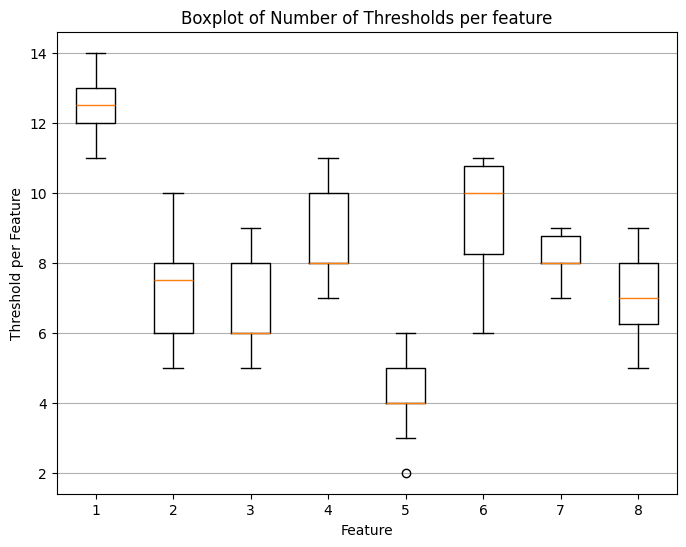

In [144]:
plt.figure(figsize=(8, 6))
plt.boxplot(feature_count_total)
plt.xlabel('Feature')
plt.ylabel('Threshold per Feature')
plt.title('Boxplot of Number of Thresholds per feature')
plt.grid(axis='y')
plt.show()

In [174]:
a_index = torch.repeat_interleave(torch.arange(num_features),feature_count)
quantile_tensor = torch.cat([torch.tensor([(f+1)/(count+1) for f in range(count)]) for count in feature_count])
a_init = torch.stack([torch.quantile(X_train_tensor[:,a_index[f]], quantile_tensor[f]) for f in range(num_thresholds)])

In [182]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = CombinedModel(compressed_model, linear_model)
combined_model.to(device);

In [189]:
## Train combined model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
n_epochs = 20
train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, device = device)

Epoch 1/20, Loss: 0.8181240281393362, Val Loss: 0.6051349089695857
Epoch 3/20, Loss: 0.474003836166027, Val Loss: 0.5495985141167274
Epoch 5/20, Loss: 0.3902636955874835, Val Loss: 0.641951322555542
Epoch 7/20, Loss: 0.32979548705178635, Val Loss: 0.44641410754277155
Epoch 9/20, Loss: 0.3050534061567728, Val Loss: 0.3761028856039047
Epoch 11/20, Loss: 0.292986071040464, Val Loss: 0.2939794957637787
Epoch 13/20, Loss: 0.27821763157266977, Val Loss: 0.30851639096553507
Epoch 15/20, Loss: 0.2773818641958773, Val Loss: 0.28536673486232755
Epoch 17/20, Loss: 0.2793928731030734, Val Loss: 0.2958116495838532
Epoch 19/20, Loss: 0.28569336249962335, Val Loss: 0.2921016165843377


0.30270549001602026

## Test with random comparisons

In [355]:
def create_indices(num_features, num_thresholds):
    """Create random indices for feature selection layer. There are (num_features)*(num_features-1)/2 of comparisons possible and 
    we select randomly num_thresholds comparisons.

    Args:
        num_features: number of features
        num_thresholds (_type_): number of thresholds

    Returns:
        Tuple of indices: If it is not possible to put all features in at least one comparison, None is returned.
    """
    first_index = torch.repeat_interleave(torch.arange(num_features-1), torch.arange(num_features-1, 0,-1))
    second_index = torch.cat([torch.arange(f+1,num_features) for f in range(num_features)])
    if num_thresholds <= len(first_index):
        selected_index = torch.randperm(len(first_index))[:num_thresholds]
    else:
        amount_of_comparisons = num_thresholds // len(first_index)
        rest_comparisons = num_thresholds % len(first_index)
        selected_index = torch.cat([torch.randperm(len(first_index)) for _ in range(amount_of_comparisons)])
        selected_index = torch.cat([selected_index, torch.randperm(len(first_index))[:rest_comparisons]])    

    first_index_selected = first_index[selected_index]
    second_index_selected = second_index[selected_index]
    counter = 0
    while not torch.sort(torch.unique(torch.cat([first_index_selected, second_index_selected])))[0].shape[0] == num_features and counter <= 10:
        selected_index = torch.randperm(len(first_index))[:num_thresholds]
        first_index_selected = first_index[selected_index]
        second_index_selected = second_index[selected_index]
        counter += 1
    if counter > 10:
        print('No valid indices found')
        return None, None
    return first_index_selected, second_index_selected


first_index, second_index = create_indices(8, 6)

In [214]:
runs = 10
device = 'cpu'
feature_count_total = torch.zeros(runs,num_features)
num_thresholds = 64
num_features = 8
for f in tqdm(range(runs)):
    n_epochs = 25
    a_init = torch.randn(num_thresholds)
    a_index = torch.arange(num_thresholds)
    first_index, second_index = create_indices(num_features, num_thresholds)
    feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
    optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    feature_index_after = combined_model_new.feature_selection_layer.get_features()
    feature_idx, feature_count = torch.unique(feature_index_after, return_counts=True)
    sort_idx = torch.argsort(feature_idx)
    feature_count = feature_count[sort_idx]
    feature_count_total[f] = feature_count

100%|██████████| 10/10 [01:57<00:00, 11.70s/it]


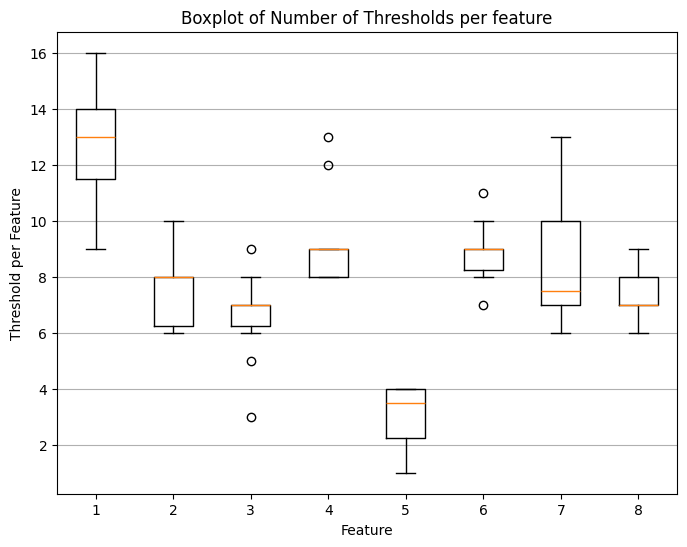

In [216]:
plt.figure(figsize=(8, 6))
plt.boxplot(feature_count_total)
plt.xlabel('Feature')
plt.ylabel('Threshold per Feature')
plt.title('Boxplot of Number of Thresholds per feature')
plt.grid(axis='y')
plt.show()

## Performance for different amount of thresholds

In [356]:
device = 'cpu'
feature_count_total = torch.empty(0,num_features)
max_number_thresholds = 64
step = 4
num_features = 8
val_losses = []
val_loss_compressed = []
for num_thresholds in tqdm(range(8,max_number_thresholds+1,step)):
    n_epochs = 25
    a_init = torch.randn(num_thresholds)
    a_index = torch.arange(num_thresholds)
    first_index, second_index = create_indices(num_features, num_thresholds)
    feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
    optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    val_loss_current = eval_val(combined_model_new, test_loader, device = device)
    val_losses.append(val_loss_current)
    val_loss_current = eval_val(combined_model_new, test_loader, eval=True, device = device)
    val_loss_compressed.append(val_loss_current)
    feature_index_after = combined_model_new.feature_selection_layer.get_features()
    feature_count = torch.zeros(num_features)
    for f in range(num_features):
        feature_count[f] = torch.sum(feature_index_after == f) / num_thresholds
    feature_count_total = torch.cat([feature_count_total, feature_count.unsqueeze(0)], dim = 0)

100%|██████████| 15/15 [02:49<00:00, 11.29s/it]


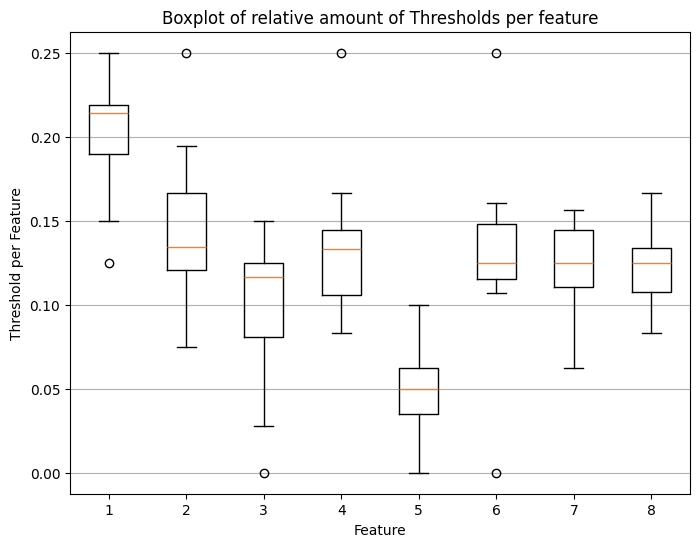

In [357]:
plt.figure(figsize=(8, 6))
plt.boxplot(feature_count_total)
plt.xlabel('Feature')
plt.ylabel('Threshold per Feature')
plt.title('Boxplot of relative amount of Thresholds per feature')
plt.grid(axis='y')
plt.show()

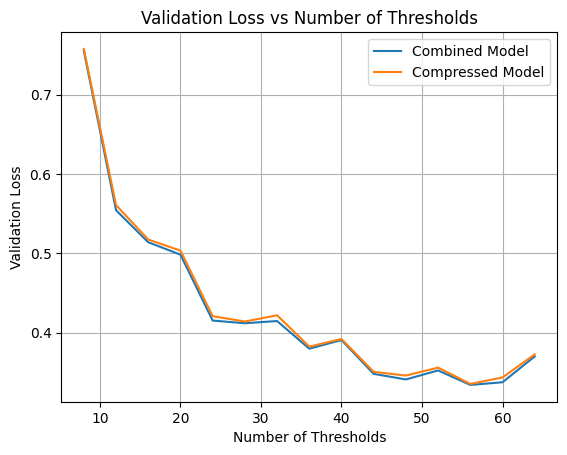

In [358]:
plt.figure()
plt.plot(range(8,max_number_thresholds+1,step), val_losses, label='Combined Model')
plt.plot(range(8,max_number_thresholds+1,step), val_loss_compressed, label='Compressed Model')
plt.xlabel('Number of Thresholds')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Number of Thresholds')
plt.legend()
plt.grid()
plt.show()

## Compare equal number of threshold per feature to trained amount of number of threshold per feature

We first train a CombinedModelNew model and then use its threshold selection to train a combined model.

In [359]:
num_thresholds = 16 
n_epochs = 25
a_init = torch.randn(num_thresholds)
a_index = torch.arange(num_thresholds)
first_index, second_index = create_indices(num_features, num_thresholds)
feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = num_thresholds,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
criterion = nn.MSELoss()
train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
feature_index_after = combined_model_new.feature_selection_layer.get_features()
for f in range(num_features):
    feature_count[f] = torch.sum(feature_index_after == f)

In [360]:
feature_count= feature_count.to(int)
a_index = torch.repeat_interleave(torch.arange(num_features),feature_count.to(int))
quantile_tensor = torch.cat([torch.tensor([(f+1)/(count+1) for f in range(count)]) for count in feature_count])
a_init = torch.stack([torch.quantile(X_train_tensor[:,a_index[f]], quantile_tensor[f]) for f in range(num_thresholds)])

In [361]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = num_thresholds,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = CombinedModel(compressed_model, linear_model)
combined_model.to(device);

In [362]:
val_losses = []
val_losses_compressed = []
num_runs = 20
for f in tqdm(range(num_runs)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    ## Train combined model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    n_epochs = 20
    train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    val_loss_current = eval_val(combined_model, test_loader, device = device)
    val_losses.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval=True, device=device)
    val_losses_compressed.append(val_loss_current)

100%|██████████| 20/20 [02:24<00:00,  7.24s/it]


In [363]:
val_losses_naiv = []
val_losses_compressed_naiv = []
a_init, a_index = initialize_a(num_features=8, num_thresholds=num_thresholds//num_features, X=X_train_tensor)
for f in tqdm(range(num_runs)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    ## Train combined model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    n_epochs = 20
    train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    val_loss_current = eval_val(combined_model, test_loader, device = device)
    val_losses_naiv.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval=True, device=device)
    val_losses_compressed_naiv.append(val_loss_current)

TypeError: initialize_a() got an unexpected keyword argument 'num_thresholds'

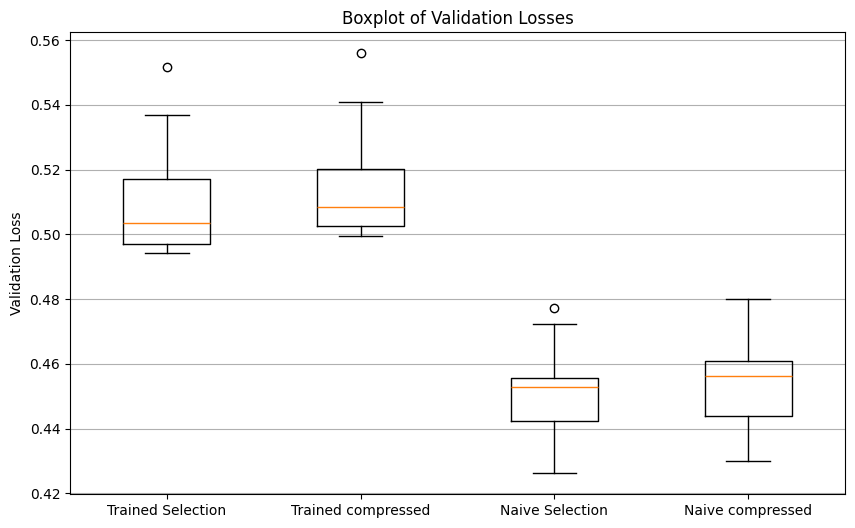

In [ ]:
plt.figure(figsize=(10,6))
plt.boxplot([val_losses, val_losses_compressed, val_losses_naiv, val_losses_compressed_naiv], tick_labels=['Trained Selection', 'Trained compressed', 'Naive Selection', 'Naive compressed'])
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()


## Linear Layer + thresholds + Linear Layer

In [49]:
class CombinedModel2(nn.Module):
    def __init__(self, start_model, compression_model, end_model):
        super().__init__()
        self.start_model = start_model
        self.compressed_model = compression_model
        self.end_model = end_model
        # self.compressed_model = compressed_model
        # self.linear_model = linear_model
    
    def forward(self, x, eval = False):
        ## x shape [B, n]
        y = self.start_model(x)
        y_comp = self.compressed_model(y)
        if eval:
            y_comp = torch.round(y_comp)
        z = self.end_model(y_comp)
        return y_comp, z

In [54]:
a_init = torch.randn(64)
a_index = torch.repeat_interleave(torch.arange(8), 8)
a_index = torch.arange(64)

In [55]:
start_model = nn.Linear(8,64)
compression_model = CompressedModel(a_init=a_init,
                                    a_index=a_index)
end_model = nn.Linear(64,8)

combined_model2 = CombinedModel2(start_model=start_model, 
                                 compression_model=compression_model,
                                 end_model=end_model)

In [56]:
train_combined(combined_model2,train_loader,test_loader,
              optimizer=torch.optim.Adam(combined_model2.parameters(), lr=0.003),
              criterion=nn.MSELoss(),
              num_epochs=20,
              device=device,
              print_result=True)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 0.9674673856690873, Val Loss: 0.5626300912636977
Epoch 3/20, Loss: 0.3965475910971331, Val Loss: 0.4198146267579152
Epoch 5/20, Loss: 0.35812894867141115, Val Loss: 0.3670101413360009
Epoch 7/20, Loss: 0.33081245485895366, Val Loss: 0.33172351374075965
Epoch 9/20, Loss: 0.3132637292146683, Val Loss: 0.31493413058611064
Epoch 11/20, Loss: 0.30043625898023907, Val Loss: 0.3087125709423652
Epoch 13/20, Loss: 0.3008881047830101, Val Loss: 0.3183946531552535
Epoch 15/20, Loss: 0.3072516247341337, Val Loss: 0.3223246420805271
Epoch 17/20, Loss: 0.318332934795424, Val Loss: 0.32263569900622735
Epoch 19/20, Loss: 0.32206095628036085, Val Loss: 0.3368849598444425


0.3339782895950171

## Try a quantization model

In [16]:
class QuantizationLayer(nn.Module):
    def __init__(self, num_features, num_thresholds_per_feature, tau = 1):
        super().__init__()
        self.num_features = num_features
        self.num_thresholds_per_feature = num_thresholds_per_feature
        self.tau = tau
        if isinstance(num_thresholds_per_feature, int):
            self.thresholds = nn.Parameter(torch.randn(num_features, num_thresholds_per_feature))
        else:
            assert len(num_thresholds_per_feature) == num_features, "num_thresholds_per_feature must be a list of length num_features"
            self.thresholds = nn.ParameterList([nn.Parameter(torch.randn(num_thresholds)) for num_thresholds in num_thresholds_per_feature])

    def set_thresholds(self,thresholds):
        if isinstance(thresholds, torch.Tensor):
            self.thresholds = nn.Parameter(thresholds)
        else:
            assert len(thresholds) == self.num_features, "thresholds must be a list of length num_features"
            for i, threshold in enumerate(thresholds):
                self.thresholds[i] = nn.Parameter(threshold)

    def forward(self, x):
        """

        Args:
            x (Tensor): shape [B, num_features]

        Returns:
            Tensor: shape [B, num_features]
        """
        if isinstance(self.thresholds, nn.ParameterList):
            for f in range(self.num_features):
                x[:,f] = torch.sigmoid((x[:,f]-self.thresholds[f]) / self.tau)
        else:
            x = torch.sigmoid((x[:,:,None]-self.thresholds[None,:]) / self.tau)
            x = torch.sum(x, dim = 2)
        return x    
                    



In [63]:
def eval_quantization(model, val_dataloader, device = 'cuda'):
    """Calculates, how far the model is from giving compressed hidden states.

    Args:
        model: important: model.forward() must return hidden_state, output
        val_dataloader: dataloader of validation set
        device (str, optional): device. Defaults to 'cuda'.

    Returns:
        : mean of the absolute difference between hidden state and rounded (i.e. compressed) hidden state
    """
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            hidden_state = model.get_quantization_layer(x)  
            hidden_state_compressed = torch.round(hidden_state) 
            loss = torch.mean(torch.abs(hidden_state - hidden_state_compressed))
            losses.append(loss.item())
        return np.mean(losses)

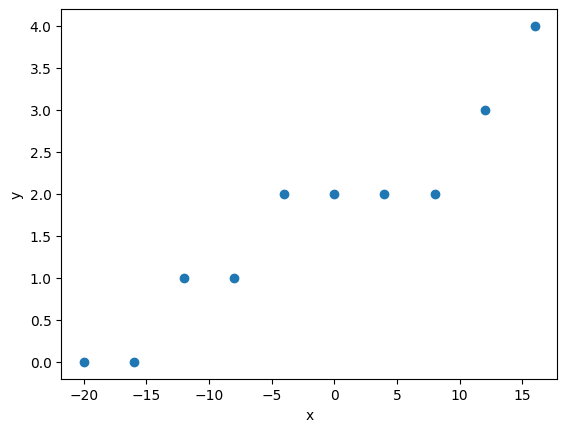

In [17]:
quantization_layer = QuantizationLayer(num_features = 1, num_thresholds_per_feature = 4, tau = 0.1)
quantization_layer.set_thresholds(torch.tensor([-15.,-5.,9.,15.]).reshape(1,4))
x = torch.arange(-20,20,4).reshape(-1,1)
y = quantization_layer(x)
plt.plot(x.detach().numpy(), y.detach().numpy(), 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [29]:
class Combined_Quantization_Model(nn.Module):
    def __init__(self, start_model, quantization_layer, end_model):
        super().__init__()
        self.start_model = start_model
        self.quantization_layer = quantization_layer
        self.end_model = end_model
        
    def forward(self, x):
        x = self.start_model(x)
        x = self.quantization_layer(x)
        x = self.end_model(x)
        return x
        
    def get_quantization_layer(self,x):
        x = self.start_model(x)
        x = self.quantization_layer(x)
        return x
    
    def set_tau(self, tau):
        self.quantization_layer.tau = tau
        
        

In [48]:
combined_quantization_model.quantization_layer.thresholds

Parameter containing:
tensor([[-2.2068, -0.8172,  0.0956,  0.6056,  0.8984,  1.9563,  1.5998,  2.4465],
        [-2.7001, -2.5454, -2.2517, -0.8179,  1.7412,  1.9682,  2.0085,  2.0615],
        [-0.9068, -0.7829, -0.2173, -0.5387, -0.5059, -0.3802, -0.7644,  1.7408],
        [-1.8092, -1.7759, -1.7247, -1.6120, -1.0573, -1.0502, -0.7873,  1.3983],
        [-1.2699,  0.2500,  0.6703, -1.1329,  1.1632,  1.0253,  0.9688,  1.5811],
        [-0.0663, -0.2490, -0.2170,  0.0227, -0.2312, -0.0628,  0.1921,  0.4525],
        [-0.5221, -0.2682, -0.5220, -0.5590, -0.3906,  0.9420,  1.2718,  1.6629],
        [-1.3925, -1.1139, -0.1664, -0.1611,  0.2065,  0.9750,  0.7740,  1.4617]],
       requires_grad=True)

In [108]:
def train_model_with_tau(model, train_loader, test_loader, optimizer, criterion, num_epochs, train_quantization_layer = True, device = 'cuda', print_result = True):
    """
    Trains a model with a quantization layer.
    """
    model.train()
    if not train_quantization_layer:
        for param in model.quantization_layer.parameters():
            param.requires_grad = False
    factor = 0.001 ** (1/num_epochs)
    for epoch in range(num_epochs):
        losses = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        model.set_tau(max(model.quantization_layer.tau * factor, 0.001))
        val_loss = eval_val(model, test_loader, criterion = criterion, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss


In [69]:
start_model = nn.Identity()
num_features = 8
num_thresholds_per_feature = 4
quantization_layer = QuantizationLayer(num_features = num_features, num_thresholds_per_feature = num_thresholds_per_feature, tau = 1)
quantiles_tensor = torch.tensor([(f+1)*1/(num_thresholds_per_feature+1) for f in range(num_thresholds_per_feature)])
cal_housing_quantiles = torch.quantile(X_train_tensor, quantiles_tensor, dim = 0).T
quantization_layer.set_thresholds(cal_housing_quantiles)
end_model = nn.Sequential(nn.Linear(num_features,64),
                          nn.ReLU(),
                          nn.Linear(64,64),
                          nn.ReLU(),
                          nn.Linear(64,1))
combined_quantization_model = Combined_Quantization_Model(start_model, quantization_layer, end_model)

In [70]:
eval_quantization(combined_quantization_model, test_loader, device = 'cpu')

0.21386856459654294

In [71]:
train_model_with_tau(combined_quantization_model, train_loader, test_loader,
                     optimizer=torch.optim.Adam(combined_quantization_model.parameters(), lr=0.003),
                     criterion=nn.MSELoss(),
                     num_epochs=20,
                     device='cpu',
                     print_result=True)


Epoch 1/20, Loss: 0.8180362599533658, Val Loss: 0.581714842411188
Epoch 3/20, Loss: 0.4741406318868778, Val Loss: 0.5210179709471189
Epoch 5/20, Loss: 0.3839770816555319, Val Loss: 0.6334444852975699
Epoch 7/20, Loss: 0.3545144493727721, Val Loss: 0.41982160187684575
Epoch 9/20, Loss: 0.33556148808362873, Val Loss: 0.4246927864276446
Epoch 11/20, Loss: 0.33250596201003985, Val Loss: 0.34537850870535924
Epoch 13/20, Loss: 0.33399556675391606, Val Loss: 0.3410318945462887
Epoch 15/20, Loss: 0.3328054654159287, Val Loss: 0.369712607218669
Epoch 17/20, Loss: 0.3361217780688474, Val Loss: 0.3533410335962589
Epoch 19/20, Loss: 0.3394612921762836, Val Loss: 0.3580583152862696


0.3515393642278818

In [72]:
eval_quantization(combined_quantization_model, test_loader, device = 'cpu')

0.004106010910338507

## Test with a small MLP per feature

In [77]:
class MLP_small_per_feature(nn.Module):
    def __init__(self, num_features, num_hidden_features):
        super().__init__()
        self.num_features = num_features
        self.num_hidden_features = num_hidden_features

        self.feature_mlps = nn.ModuleList([nn.Sequential(nn.Linear(1,num_hidden_features),
                                                          nn.ReLU(),
                                                          nn.Linear(num_hidden_features,num_hidden_features),
                                                          nn.ReLU(),
                                                          nn.Linear(num_hidden_features,1)) for _ in range(num_features)])

    def forward(self, x):
        x = x.view(-1, self.num_features)
        x = torch.cat([self.feature_mlps[f](x[:,f].unsqueeze(-1)) for f in range(self.num_features)], dim = 1)
        return x


In [147]:

num_features = 8
start_model = MLP_small_per_feature(num_features, num_hidden_features = 16)

num_thresholds_per_feature = 4
quantization_layer = QuantizationLayer(num_features = num_features, num_thresholds_per_feature = num_thresholds_per_feature, tau = 1)
quantiles_tensor = torch.tensor([(f+1)*1/(num_thresholds_per_feature+1) for f in range(num_thresholds_per_feature)])
cal_housing_quantiles = torch.quantile(X_train_tensor, quantiles_tensor, dim = 0).T
quantization_layer.set_thresholds(torch.arange(num_thresholds_per_feature).view(1,-1).expand(num_features,num_thresholds_per_feature).to(torch.float))
end_model = nn.Sequential(nn.Linear(num_features,64),
                          nn.ReLU(),
                          nn.Linear(64,64),
                          nn.ReLU(),
                          nn.Linear(64,1))
combined_quantization_model = Combined_Quantization_Model(start_model, quantization_layer, end_model)

In [148]:
eval_quantization(combined_quantization_model, test_loader, device = 'cpu')

0.06792011559009552

In [150]:
train_model_with_tau(combined_quantization_model, train_loader, test_loader,
                     optimizer=torch.optim.Adam(combined_quantization_model.parameters(), lr=0.003),
                     criterion=nn.MSELoss(),
                     num_epochs=20,
                     device='cpu',
                     print_result=True,
                     train_quantization_layer=False)


Epoch 1/20, Loss: 0.5214140461974366, Val Loss: 0.5177442752397977
Epoch 3/20, Loss: 0.47980411368054016, Val Loss: 0.4536148291367751
Epoch 5/20, Loss: 0.4496545815883681, Val Loss: 0.4593247613081565
Epoch 7/20, Loss: 0.45362630769494894, Val Loss: 0.4541406438900874
Epoch 9/20, Loss: 0.48291242001361623, Val Loss: 0.4718901492082156
Epoch 11/20, Loss: 0.43934178115554556, Val Loss: 0.45394188922185164
Epoch 13/20, Loss: 0.47458669884029286, Val Loss: 0.4505320512331449
Epoch 15/20, Loss: 0.4603708392774412, Val Loss: 0.4221560599712225
Epoch 17/20, Loss: 0.4132575786621996, Val Loss: 0.3912874510655036
Epoch 19/20, Loss: 0.416108952936276, Val Loss: 0.41397519661830023


0.41495089828968046

In [145]:
eval_quantization(combined_quantization_model, test_loader, device = 'cpu')

0.0008416150792654138

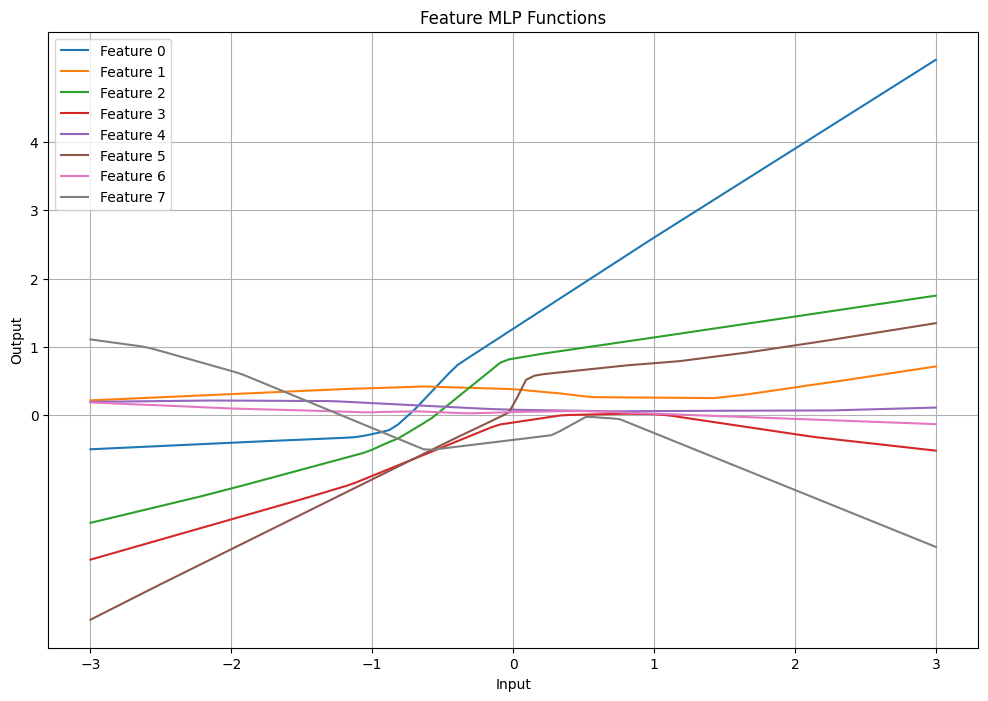

In [139]:
import numpy as np
import matplotlib.pyplot as plt

x_range = np.linspace(-3, 3, 100)
num_features = 8

plt.figure(figsize=(12,8))
for k in range(num_features):
    # Convert input to tensor and reshape for model
    x_tensor = torch.tensor(x_range, dtype=torch.float32).reshape(-1,1)
    
    # Get output from kth feature MLP
    with torch.no_grad():
        y = combined_quantization_model.start_model.feature_mlps[k](x_tensor)
    
    # Plot the function
    plt.plot(x_range, y.numpy(), label=f'Feature {k}')

plt.yticks(np.arange(0,4.2,1))
plt.xlabel('Input')
plt.ylabel('Output') 
plt.title('Feature MLP Functions')
plt.legend()
plt.grid(True)
plt.show()


In [140]:
x_test = torch.zeros(8,1)
x_start = combined_quantization_model.start_model(x_test)
x_quantized = combined_quantization_model.quantization_layer(x_start)

In [141]:
x_quantized

tensor([[2., 1., 1., 0., 1., 1., 1., 0.]], grad_fn=<SumBackward1>)

In [138]:
combined_quantization_model.quantization_layer.thresholds


Parameter containing:
tensor([[0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.]])

## Try a model that uses Sigmoid activation in the first layer

In [58]:
class ScaleLayer(nn.Module):
    def __init__(self, scale_factor=1.0):
        super().__init__()
        self.scale = scale_factor
    
    def forward(self, x):
        return x * self.scale

In [63]:
model = nn.Sequential(nn.Linear(8,64),
                    ScaleLayer(scale_factor=1),
                    nn.Sigmoid(),
                    nn.Linear(64,64),
                    nn.ReLU(),
                    nn.Linear(64,64),
                    nn.ReLU(),
                    nn.Linear(64,1))

In [64]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print_result = True):
    """Trains a model. 

    Args:
        model: model
        train_dataloader: dataloader of training set
        val_dataloader: dataloader of validation set	
        optimizer: optimizer to use
        criterion: loss criterion
        num_epochs: number of epochs to train
        device (str, optional): device. Defaults to 'cuda'.
        print_result (bool, optional): If true, method prints intermediate results. Defaults to True.

    Returns:
        val_loss: validation loss
    """
    factor = 0.001 ** (1/num_epochs)

    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        model[1].scale = max(model[1].scale * factor, 0.001)
        val_loss = eval_val(model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss        

In [65]:
train_model(model, train_loader, test_loader,
            optimizer=torch.optim.Adam(model.parameters(), lr=0.003),
            criterion=nn.MSELoss(),
            num_epochs=20,
            device=device,
            print_result=True)

Epoch 1/20, Loss: 0.7806718780897385, Val Loss: 0.5089488930427111
Epoch 3/20, Loss: 0.42790850661983787, Val Loss: 0.5245824061907255
Epoch 5/20, Loss: 0.4342826112758282, Val Loss: 0.45899148950209984
Epoch 7/20, Loss: 0.430949596644834, Val Loss: 0.4576666790705461
Epoch 9/20, Loss: 0.45397783232520716, Val Loss: 0.5576832189009739
Epoch 11/20, Loss: 0.4848054700004038, Val Loss: 0.49951683374551625
Epoch 13/20, Loss: 0.48541365176901335, Val Loss: 0.5331974474283365
Epoch 15/20, Loss: 0.5061578335919121, Val Loss: 0.6373791171954228
Epoch 17/20, Loss: 0.5816684836565063, Val Loss: 0.6565564210598286
Epoch 19/20, Loss: 0.680282751603644, Val Loss: 0.6997122526168823


0.881062258206881

In [70]:
compression_differ = []
for x,y in test_loader:
    hidden = model[0](x)
    compression_differ.append(torch.mean(torch.abs(hidden - torch.round(hidden))))

torch.mean(torch.tensor(compression_differ))   

tensor(0.2497)

## Include extra loss (does not work)

This dows not work at the moment. Problem is that it produces nan values after a few training steps. 

In [71]:
class extra_loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, hidden_state, output, target):
        mse = torch.mean((output - target)**2)
        compress_loss = torch.mean(hidden_state * (1- hidden_state))
        return mse + compress_loss

In [75]:
a_init, a_index = initialize_a(num_features=8, num_thresholds_per_feature=8, X=X_train_tensor)

In [76]:
compressed_model_new = CompressedModel(a_init, a_index)
linear_model_new = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 10,
                        num_layers = 3)
combined_model_new = CombinedModel(compressed_model_new, linear_model_new)
combined_model_new.to(device);

In [77]:
loss_fn = extra_loss()
x,y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)
hidden_state, output  = combined_model_new(x)
loss_fn(hidden_state, output, y)

tensor(6.3939, grad_fn=<AddBackward0>)

In [79]:
mse = torch.mean((output - y)**2)
compress_loss = torch.mean(hidden_state * (1- hidden_state))
alt = torch.mean(torch.abs(hidden_state - torch.round(hidden_state)))
mse, compress_loss, alt 

(tensor(6.1839, grad_fn=<MeanBackward0>),
 tensor(0.2100, grad_fn=<MeanBackward0>),
 tensor(0.3521, grad_fn=<MeanBackward0>))

In [81]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.0001)
n_epochs = 100
device= 'cpu'
combined_model.to(device);

for epoch in range(n_epochs):
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        hidden_state, output = combined_model_new(x)
        loss = loss_fn(hidden_state, output, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # combined_model.compressed_model.tau = combined_model.compressed_model.tau* 0.95    
    if epoch % (n_epochs//10) == 0:
        print(f'{epoch}: {np.mean(losses)}')

0: 6.199729607086773
10: 1.067455493202505
20: 0.8122804661591848
30: 0.7675703157519185
40: 0.736268414429916
50: 0.7149834329074667
60: 0.7005714881558751
70: 0.6905373176632001
80: 0.683057212552359
90: 0.6765255211859711


In [83]:
val_loss = eval_val(combined_model_new, test_loader, device = device)
print(f'Val Loss: {val_loss}')

Val Loss: 0.5105142052357013
